# Homework 2, Grossrieder Wanchai 301436 code

We load the necessary libraries.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


_____________________________________

## The different convolution methods
It takes the a matrix of size num node, output features and return it back with the new features as shown in this picture :

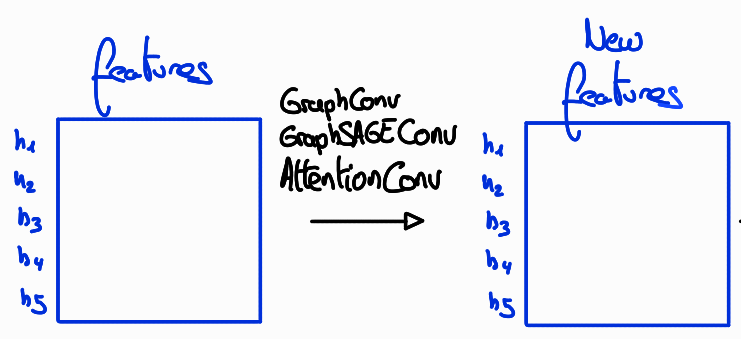

each row of the matrix represent a node and each column a feature.

#### we have implemented 3 different kinds of convolutions : Graph convolution, GraphSAGE, Attention

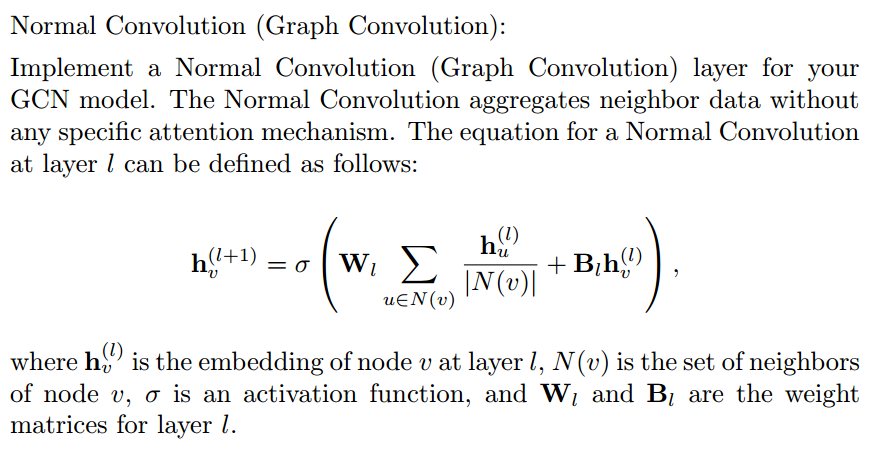

In [3]:
class GraphConv(nn.Module):

    def __init__(self, in_features, out_features, aggregation = "mean", activation=None):
        """
        Initialize the modified graph convolutional layer.
        
        Args:
            in_features (int): Number of input node features.
            out_features (int): Number of output node features.
            activation (nn.Module or callable): Activation function to apply. (optional)
        """
        super().__init__()
        # Activation function to apply
        self.activation = activation
        # Infeatures: number of input features per node
        self.in_features = in_features
        # Outfeatures: number of output features per node
        self.out_features = out_features
        # Aggregation function: which is applied to aggregate
        self.aggregation = aggregation

        # Learnable weight matrices, using linear
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)  # Adding a learnable bias term

    def forward(self, x, adj):
        """
        Perform node-wise graph convolution operation for one node at a time.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after node-wise graph convolution, shape (1, out_features).
        """
        # Get the number of nodes
        num_nodes = x.size(0)
         #initialize the output features returned by the function
        output_features = torch.zeros(num_nodes, self.out_features, device=x.device)

        
        for node_idx in range(num_nodes):
            # Calculate neighbors
            neighbors = adj[node_idx].nonzero().squeeze(dim=1)
            # Aggregate neighbor features
            if neighbors.numel() > 1:
                # Aggregate neighbor features if the node has neighbors
                if self.aggregation == "mean" :
                    x_agg = torch.mean(x[neighbors], dim=0, keepdim=True)
                elif self.aggregation == "max" :
                    x_agg,_ = torch.max(x[neighbors], dim=0, keepdim=True)
                else :
                    raise ValueError("Aggregation type not supported.")
            else:
                # If the node has no neighbors, set the aggregated features to zero
                x_agg = torch.zeros_like(x[node_idx]).unsqueeze(dim=0)
            
            # Calculate the updated node features
            w_xt = self.weight(x_agg)
            b_xt = self.bias(x[node_idx])
            node_output = w_xt + b_xt
            
            

            # Apply activation function (e.g., ReLU)
            if self.activation is not None:
                node_output = self.activation(node_output).squeeze()

            # Save the updated node features
            output_features[node_idx] = node_output

        return output_features


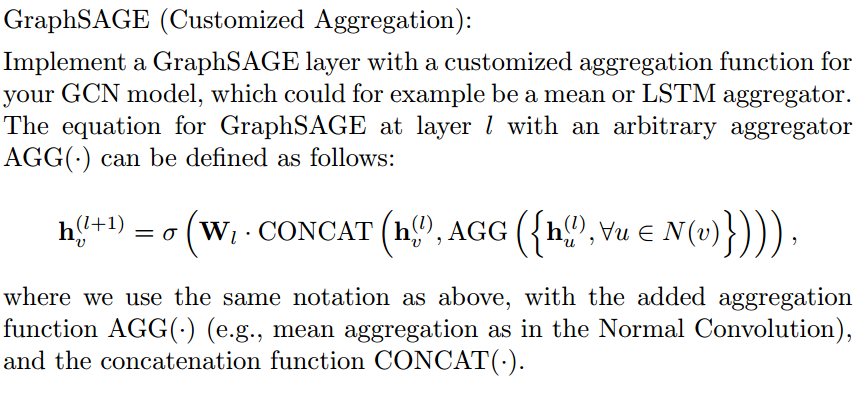

In [4]:
class GraphSAGEConv(nn.Module):
    def __init__(self, in_features, out_features, aggregation ="mean", activation=None):
        """
        Initialize the GraphSAGEConv layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            aggregation (str): Aggregation method to use
            activation (callable): Activation function to apply after the linear transformation.
        """
        super(GraphSAGEConv, self).__init__()
        # Infeatures: number of input features per node
        self.in_features = in_features
        # Outfeatures: number of output features per node
        self.out_features = out_features
        # Activation function : which is applied to the updated node features
        self.activation = activation
        # Aggregation function: which is applied to aggregate the neighbor information
        self.aggregation = aggregation

        # Initialize the linear weights
        self.weights = nn.Linear(2 * in_features, out_features)

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Get the number of nodes
        num_nodes = x.size(0)
        #initialize the output features returned by the function
        output_features = torch.zeros(num_nodes, self.out_features, device=x.device)

        for node_idx in range(num_nodes):
            # Get the neighbors of the current node based on the adjacency matrix
            neighbors = adj[node_idx].nonzero().squeeze(dim=1)

            # Handle isolated nodes: If no neighbors, use the node's own features
            if neighbors.numel() == 0:
                x_agg = x[node_idx]
            else:
                # Aggregate neighbor features
                if self.aggregation == "mean" :
                    x_agg = torch.mean(x[neighbors], dim=0)
                elif self.aggregation == "max" :
                    x_agg,_ = torch.max(x[neighbors], dim=0)
                else :
                    raise ValueError("Aggregation type not supported.")
                
            # Concatenate the original node features with the aggregated node features
            x_concat = torch.cat([x[node_idx], x_agg], dim=0)

            # Apply the weights
            x_out = self.weights(x_concat)

            # Apply activation function (e.g., ReLU)
            if self.activation:
                x_out = self.activation(x_out)

            # Save the output features
            output_features[node_idx] = x_out

        return output_features

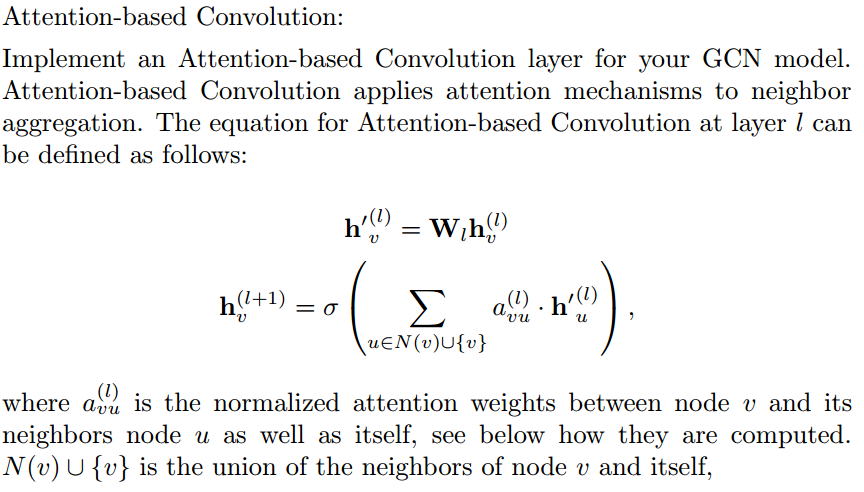
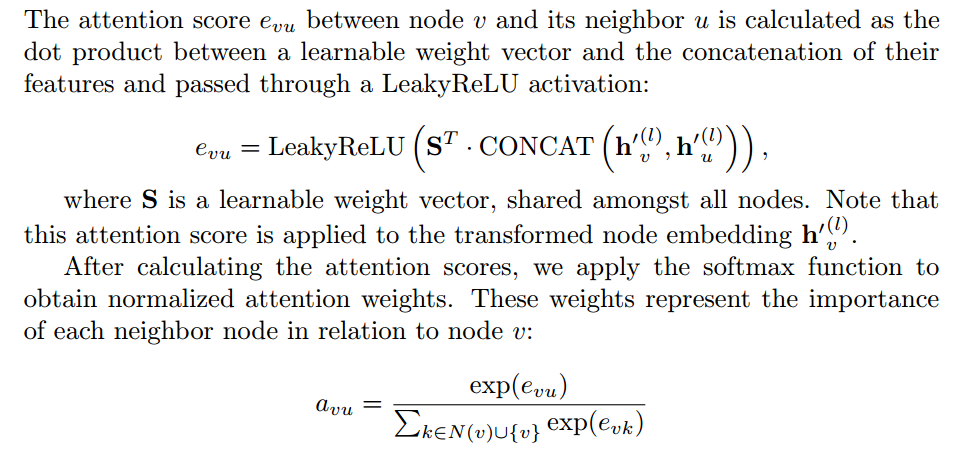

In [5]:
class AttentionConv(nn.Module):
    def __init__(self, in_features, out_features, aggregation = "sum", activation=None):# according to the statements, the aggregation should be sum
        
        super(AttentionConv, self).__init__()
        # Initialize the layer parameters
        # Infeatures: number of input features per node
        self.in_features = in_features
        # Outfeatures: number of output features per node
        self.out_features = out_features
        # Activation function : which is applied to the updated node features
        self.activation = activation
        # Aggregation function: which is applied to aggregate the neighbor information
        self.aggregation = aggregation

        # Initialize the attention mechanism parameters
        self.weights = nn.Linear(in_features, out_features)
        # Attention mechanism parameters
        self.attention_s_t = nn.Linear(2 * out_features, 1) #correspond to S.T

    def forward(self, x, adj):
        """
        Perform graph convolution operation with attention mechanism.
        x: Node features, shape [N, in_features]
        adj: Adjacency matrix, shape [N, N]

        Returns:
        -------
        out: Updated node features, shape [N, out_features]
        """
        # Linearly transform node features
        x_transformed = self.weights(x)  # Shape: (N, out_features)
        num_nodes = x.size(0)
        #initialize the output features returned by the function
        output_features = torch.zeros(num_nodes, self.out_features, device=x.device)

        # Check if all nodes are connected to at least one other node
        if (adj.sum(dim=1) == 0).any():
            raise ValueError("Not all nodes are connected to at least one other node.")

        for node_idx in range(num_nodes):
            # Get the neighbors of the current node
            neighbors = adj[node_idx].nonzero().squeeze(dim = 1)  # Shape: (num_neighbors)
            # Initialize attention scores for the current node
            attention_scores = torch.zeros(len(neighbors))

            for i, neighbor_idx in enumerate(neighbors):
                # Create queries and keys for attention for the current node and its neighbors
                h_v = x_transformed[node_idx]  
                h_u = x_transformed[neighbor_idx] 

                # Calculate attention score for the current neighbor
                concat = torch.cat([h_v.unsqueeze(0), h_u.unsqueeze(0)], dim=-1)  # Shape: (1, 2 * out_features)
                # Attention score for the current neighbor
                attention_scores[i] = F.leaky_relu(self.attention_s_t(concat))

            # Set attention scores to -inf for nodes not connected to the current node
            attention_scores[adj[node_idx, neighbors] == 0] = float("-inf")

            # Normalize attention scores a_uv = e_uv / sum(e_uv)
            attention_weights = F.softmax(attention_scores, dim=0)

            # Aggregate neighbor informationm, default is sum as in the statements
            if self.aggregation == "sum":
                aggregated = torch.sum(attention_weights.unsqueeze(1) * x_transformed[neighbors], dim=0)
            elif self.aggregation == "mean":
                aggregated = torch.mean(attention_weights.unsqueeze(1) * x_transformed[neighbors], dim=0)
            elif self.aggregation == "max":
                aggregated, _ = torch.max(attention_weights.unsqueeze(1) * x_transformed[neighbors], dim=0)
            else:
                raise ValueError("Aggregation type not supported.")

            # Apply activation function
            if self.activation is not None:
                aggregated = self.activation(aggregated)

            # Update the output features
            output_features[node_idx] = aggregated

        return output_features

I have implemented the 3 different methods, one considering only the nodes and two considering the nodes and the edges.

_______________________________________________________

## Part 1 : only the node features

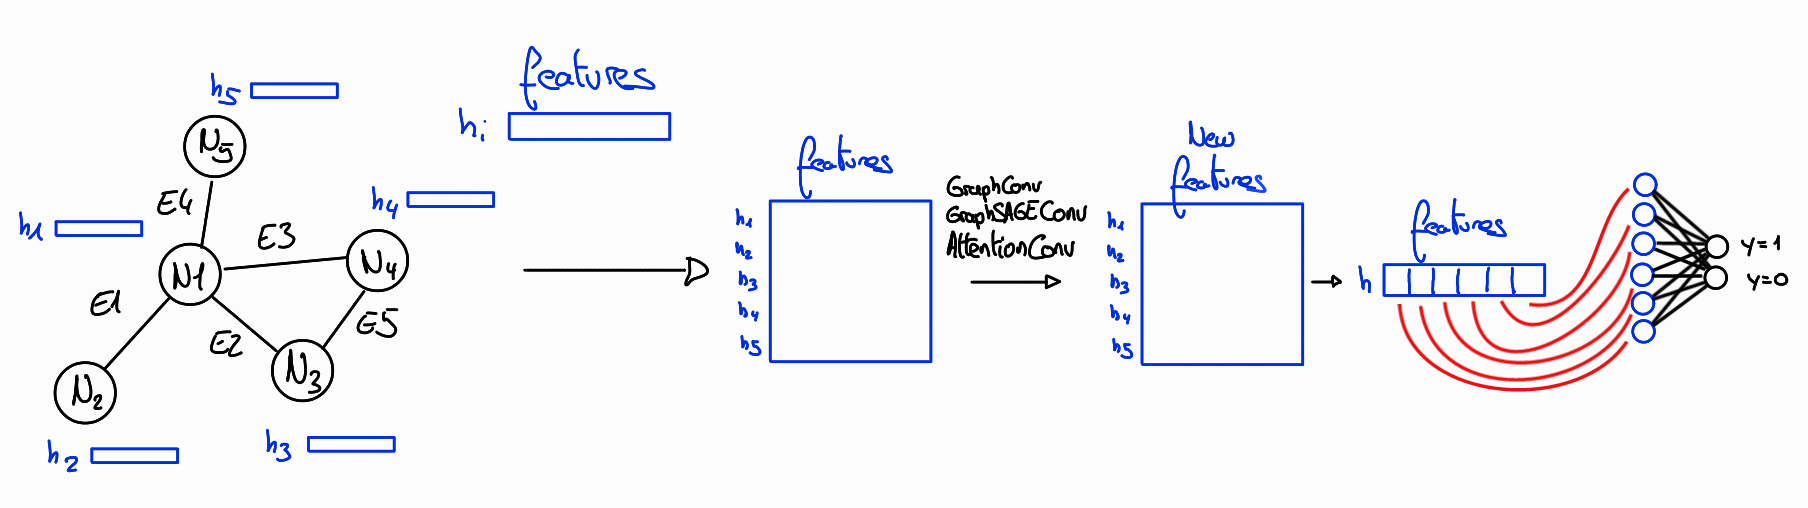

The model is composed of two parts: a part with a convolution part with a pooling layer and a neural network. The convolution part updates the features, the features are pooled by choosing either a max pooling or a mean pooling. Then the features are sent to the neural network to predict the class of the molecule. 

### We load the data + explore it using pandas (node only)

In [6]:
#Load the data into a DataFrame
df = pd.read_json('full.jsonl', lines=True)
df.head()

,edge_index,node_feat,edge_attr,y,num_nodes
0,"[[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[1],17
1,"[[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[0],13
2,"[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[0],13
3,"[[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[1],19
4,"[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[0],11


In [7]:
# Show what is the egde_index
print(df['edge_index'][0])

[[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 16], [1, 5, 0, 2, 1, 3, 2, 4, 9, 3, 5, 6, 0, 4, 4, 7, 6, 8, 7, 9, 13, 3, 8, 10, 9, 11, 10, 12, 11, 13, 14, 8, 12, 12, 15, 16, 14, 14]]


In [8]:
# Find the ratio of y=1 over all y

# Calculate the count of y=1
count_y_equals_1 = df[df['y'].apply(lambda x: 1 in x)]['y'].count()

# Calculate the total count of all y values
total_count_y = df['y'].count()

ratio_y_equals_1 = count_y_equals_1 / total_count_y
print("Ratio of y=1 over all y:", ratio_y_equals_1)


Ratio of y=1 over all y: 0.6648936170212766


we have 66% of all y = 1, so we have a "balanced" dataset.

In [9]:
# show the size of the totatl data
df.shape

(188, 5)

We take back the information from the data description

Each row of a given file is a graph, with:

- node_feat (list: #nodes x #node-features): nodes
- edge_index (list: 2 x #edges): pairs of nodes constituting edges
- edge_attr (list: #edges x #edge-features): for the aforementioned edges, contains their features (edge features)
- y (list: 1 x #labels): contains the number of labels available to predict (here 1, equal to zero or one)
- num_nodes (int): number of nodes of the graph

We replace edge_index by an adjency matrix

In [10]:
# function that transforms the edge_index to adjacency matrix
def edge_index_to_adjacency_matrix(edge_index, num_nodes):
    """
    Convert edge index representation to an adjacency matrix.

    Args:
        edge_index (numpy matrix): pairs of nodes constituting edges
        num_nodes (int): number of nodes in the graph

    Returns:
        numpy matrix: adjency matrix of the graph
    """
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(0, len(edge_index), 2):
        src, tgt = edge_index[i], edge_index[i+1]
        adj_matrix[src, tgt] = 1
        adj_matrix[tgt, src] = 1  # Assuming the graph is undirected
    return adj_matrix

In [11]:
# Replace edge_index with adjacency matrices
df['edge_index'] = df.apply(lambda row: edge_index_to_adjacency_matrix(row['edge_index'], row['num_nodes']), axis=1)


#### We split the data into train, validation, test set with 70%, 15%, 15% of the data (node only)

In [12]:
# Define the desired percentages for training, testing, and validation
train_percent = 0.7
test_percent = 0.15
validation_percent = 0.15

# Shuffle the DataFrame randomly
df = df.sample(frac=1, random_state=42)

# define the number of rows in each set. We set the number of rows to be integers, we set first the row for the training, test set, and then rest for the validation set
total_rows = len(df)
train_size = int(train_percent * total_rows)
test_size = int(test_percent * total_rows)

# Create training, testing, and validation sets
train_set = df.iloc[:train_size]
test_set = df.iloc[train_size:(train_size + test_size)]
validation_set = df.iloc[(train_size + test_size):]

# Print the number of rows in each set
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")
print(f"Validation set size: {len(validation_set)}")


Training set size: 131
Testing set size: 28
Validation set size: 29


#### Transform in pytorch and use a dataloader (node only)

In [13]:
class GraphDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the GraphDataset.

        Args:
            dataframe (pandas.DataFrame): A DataFrame containing graph data, where each row
                represents a graph
        """
        self.dataframe = dataframe

    def __len__(self):
        """
        Get the number of graphs in the dataset.

        Returns:
            int: The number of graphs.
        """
        return len(self.dataframe)

    #get the value of each column
    def __getitem__(self, idx):
        """
        Get graph data at a specified index.

        Args:
            idx (int): Index of the graph in the dataset.

        Returns:
            torch.Tensor: Edge indices for the graph.
            torch.Tensor: Node features for the graph.
            torch.Tensor: Edge attributes for the graph.
            torch.Tensor: Labels for the graph.
            int: Number of nodes in the graph.
        """
        edge_index = torch.tensor(self.dataframe.iloc[idx]['edge_index'])
        node_feat = torch.tensor(self.dataframe.iloc[idx]['node_feat'])
        edge_attr = torch.tensor(self.dataframe.iloc[idx]['edge_attr'])
        y = torch.tensor(self.dataframe.iloc[idx]['y'])
        num_nodes = self.dataframe.iloc[idx]['num_nodes']

        return edge_index, node_feat, edge_attr, y, num_nodes
    
def custom_collate(batch):

    """
    Custom collate function for batching graph data. Given a batch of graph samples, 
    it separates and returns five lists.

    Args:
        batch (list): A list of graph data, where each item is a tuple containing
                      (edge_index, node_feat, edge_attr, y, num_nodes) for a graph.

    Returns:
        tuple: A tuple containing five lists, each containing the collected data from the batch:
            - edge_index: List of edge indices for each graph.
            - node_feat: List of node features for each graph.
            - edge_attr: List of edge attributes for each graph.
            - y: List of target labels for each graph.
            - num_nodes: List of the number of nodes for each graph.
    """
    edge_index = [item[0] for item in batch]
    node_feat = [item[1] for item in batch]
    edge_attr = [item[2] for item in batch]
    y = [item[3] for item in batch]
    num_nodes = [item[4] for item in batch]
    
    return edge_index, node_feat, edge_attr, y, num_nodes

In [14]:
# transform from a pandas dataframe to a sth that pytorch can use
train_dataset = GraphDataset(train_set)
test_dataset = GraphDataset(test_set)
validation_dataset = GraphDataset(validation_set)

In [15]:
# Create DataLoader with custom collate function
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

# Inspect the first batch
for i, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes) in enumerate(train_dataloader):
    if i == 0:
        print("Batch:", i+1)
        print("Batch Edge Index:", batch_edge_index[0])
        print("Batch Node Features:", batch_node_feat[0])
        print("Batch Edge Attributes:", batch_edge_attr[0])
        print("Batch Labels:", batch_y[0])
        print("Batch Number of Nodes:", batch_num_nodes[0])
        
        # Stop after the first batch for demonstration
        break


Batch: 1
Batch Edge Index: tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 

we want to determine the number of features in the graph and see if there is the same number of features in all graphs. For that we check that the min number of features is the same as the max number of features.

In [16]:
# Initialize variables
max_features = 0
min_features = 10000000000

# Loop through each row in the 'node_feat' column
for row in df['node_feat']:
    # we suppose that inside the graph, all the nodes have the same number of features, we take only the number of features of the first node
    num_features = len(row[0]) if row else 0 
    # Update max and min number of features
    max_features = max(max_features, num_features)
    min_features = min(min_features, num_features)

# we set the number of features to be the max number of features
num_features_df = max_features

print("Max number of features:", max_features)
print("Min number of features:", min_features)

Max number of features: 7
Min number of features: 7


We now have a data type that can be send to pytorch and be used for training.

### Define graph neural network that will predict the mutagenicity

We define a GNN that will be trained which correspond to this part in the picture :

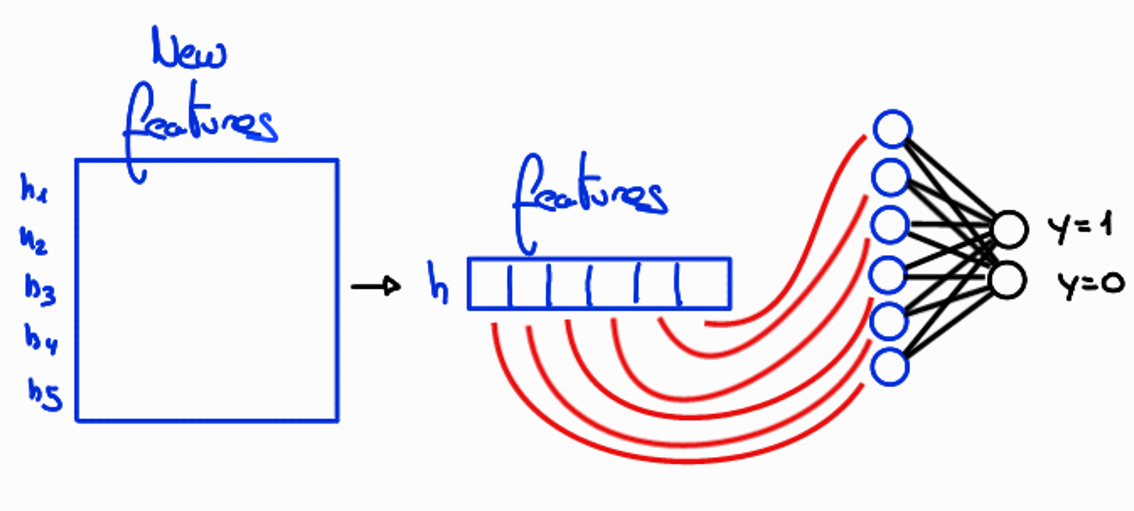

In [17]:
class CustomGraphNetwork(nn.Module):
    def __init__(self, num_in_features, numb_out_features, conv_layers, aggregation, number_of_hidden_neurons = []):
        """
        Initialize the custom graph neural network.

        Args:
            num_in_features (int): Number of input node features.
            num_out_features (int): Number of output features for each convolutional layer.
            conv_layers (nn.ModuleList): List of graph convolutional layer instances.
            aggregation (nn.Module): Instance of pooling layer.
            number_of_hidden_neurons (list): List of hidden layer sizes for fully connected layers.
        """
     
        super(CustomGraphNetwork, self).__init__()
        # Infeatures: number of input features per node
        self.num_in_features = num_in_features
        # Outfeatures: number of output features per node
        self.num_out_features = numb_out_features
        
        # Convolutional layers
        self.conv_layers = nn.ModuleList(conv_layers)
        
        # Aggregation function: which is applied to aggregate into a shape 1, out_features        
        self.aggregation = aggregation
        
        # list of hidden layer sizes for fully connected layers
        self.number_of_hidden_neurons = number_of_hidden_neurons
        self.fully_connected = nn.ModuleList()
        in_features_of_fully_connected = self.num_out_features
        # build of the fully connected layers
        for i in number_of_hidden_neurons:
            self.fully_connected.append(nn.Linear(in_features_of_fully_connected, i))
            in_features_of_fully_connected = i
        # add the last fully connected layer
        self.fully_connected.append(nn.Linear(in_features_of_fully_connected, 2))    
        
    def forward(self, x,adj):
        """
        Forward pass through the custom graph neural network.

        Args:
            x (Tensor): Input node features, shape (num_nodes, num_in_features).
            adj (Tensor): Adjacency matrix, shape (num_nodes, num_nodes).

        Returns:
            Tensor: with the probality of each graph to be in the class 0 or 1
        """
        

        # Pass input through each graph convolutional layer        
        for conv_layer in self.conv_layers:
            x = conv_layer(x, adj)  # Pass adjacency matrix to the convolutional layer
        graph_output = x

        # Apply global pooling along the node dimension (dimension 1)
        if self.aggregation == "mean" :
            graph_output = torch.mean(graph_output, dim=0, keepdim=False)
        elif self.aggregation == "max" :
            graph_output, _ = torch.max(graph_output, dim=0, keepdim=False)
        else :
            raise ValueError("Aggregation type not supported.")
              

        # Apply the fully connected layers        
        for fc_layer in self.fully_connected:
            graph_output = fc_layer(graph_output)

        # Apply softmax activation
        softmax_output = torch.softmax(graph_output, dim=0) 

        return softmax_output

### Train with only the node features, create a function that will train the model and return the loss and accuracy

In [18]:
def train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate):
    """
    Train a GNN using a training loop.

    Parameters:
    - model: The machine learning model to be trained.
    - optimizer: The optimizer for updating model parameters.
    - criterion: The loss function used for optimization.
    - train_dataloader: DataLoader providing training data.
    - num_epochs: The number of training epochs.
    - learning_rate: The learning rate for gradient descent.

    Returns:
    - trained_model: The trained machine learning model.
    - training_accuracy: The overall training accuracy across all epochs.
    - losses: A list of losses during training.
    """
    # Initialize variables for training accuracy and losses    
    correct_train_predictions = 0
    total_train_samples = 0
    losses = []
    
    # Clear gradients
    optimizer.zero_grad()
    model.train()  # Set the model to training mode
    
    
    # Training loop, epoch by epoch
    for epoch in range(num_epochs):
        # Initialize variables for training accuracy and losses for each epoch
        sub_accuracy_list = []
        correct_train_predictions_epoch = 0
        total_train_samples_epoch = 0      

        # Loop through each batch in the training dataloader
        for idx, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes) in enumerate(train_dataloader):
            
            # loop through each graph in the batch
            for i in range(len(batch_edge_index)):
                
                # Extract features, adjency matrix and labels for the current graph
                node_features = batch_node_feat[i].float()
                adj_matrix = batch_edge_index[i].float()
                ground_truth_labels = batch_y[i].clone()
                
                # Convert labels to one-hot labels
                one_hot_labels = torch.zeros((ground_truth_labels.size(0), 2))
                one_hot_labels.scatter_(1, ground_truth_labels.view(-1, 1), 1).squeeze_()
                
                # Forward pass, make a prediction
                output = model(node_features, adj_matrix)

                # Calculate the predicted class based on probability of the output
                predicted_class = (output > 0.5).long()
                # condition : if the prediction == ground truth -> add 1 to the correct_train_predictions
                condition = (predicted_class == one_hot_labels).all().item()
                if condition:
                    correct_train_predictions += 1
                    correct_train_predictions_epoch = correct_train_predictions_epoch + 1
                #Calculate the total number of samples
                total_train_samples += 1
                total_train_samples_epoch = total_train_samples_epoch + 1  
                
                # transform the output to probabilities for loss calculation
                output_probabilities = output[1]  # Select the second element (probability for class 1)
                ground_truth_labels =  ground_truth_labels.squeeze()
                output_logits = torch.log(output_probabilities / (1 - output_probabilities))# Calculate the logits for the loss function
                # Calculate the loss
                loss = criterion(output_logits, ground_truth_labels.float())
                losses.append(loss.cpu().detach().numpy())

                # Backpropagation
                loss.backward()
                # optimizer.step()
                # Optimizer step does not work, Update weights using gradient descent we do this manually because I do not understand why optimizer.step() does not work :@              
                with torch.no_grad(): 
                    for name, param in model.named_parameters():
                        param -= learning_rate * param.grad
                            
        # Calculate training accuracy
        training_accuracy = (correct_train_predictions_epoch / total_train_samples_epoch) * 100
        sub_accuracy_list.append(training_accuracy)
        
        # Print training accuracy for each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {training_accuracy:.2f}%")
        
        #Calculate the mean of the accuracy for all the epochs
        training_accuracy_final = (correct_train_predictions / total_train_samples) * 100

    return model, training_accuracy_final, losses


### Validate with only the node features, create a function that will train the model and return the loss and accuracy

In [19]:
def validate_model(model, validation_dataloader, criterion):
    """
    Validate a GNN using a validation loop.

    Parameters:
    - model: The machine learning model to be trained.
    - validation_dataloader: DataLoader providing training data.
    - criterion: The loss function used for optimization.

    Returns:
    - average_validation_loss: the average validation loss
    - validation_accuracy: The overall validation accuracy across all epochs.
    """
    
    # Set the model to evaluation mode (no gradient updates)
    model.eval()  
    
    # Initialize variables for validation accuracy and loss
    # We have for each two numbers so we can calculate the mean of the accuracy and loss
    total_validation_loss = 0.0
    validation_batches = 0

    correct_train_predictions = 0
    total_train_samples = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for idx, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes) in enumerate(validation_dataloader):
            for i in range(len(batch_edge_index)):
                # Extract features, adjency matrix and labels for the current graph
                node_features = batch_node_feat[i].float()
                adj_matrix = batch_edge_index[i].float()
                ground_truth_labels = batch_y[i].clone().detach()

                # Convert labels to one-hot labels
                one_hot_labels = torch.zeros((ground_truth_labels.size(0), 2))
                one_hot_labels.scatter_(1, ground_truth_labels.view(-1, 1), 1).squeeze_()

                # Forward pass
                output = model(node_features, adj_matrix)

                # Calculate the predicted class based on probability of the output
                predicted_class = (output > 0.5).long()
                # condition : if the prediction == ground truth -> add 1 to the correct_train_predictions
                condition = (predicted_class == one_hot_labels).all().item()
                if condition:
                    correct_train_predictions += 1
                total_train_samples += 1

                # Compute the validation loss
                validation_loss = criterion(output, one_hot_labels)
                
                # add the validation loss to the total validation loss
                total_validation_loss += validation_loss.item()
                validation_batches += 1

    # Calculate the average validation loss
    average_validation_loss = total_validation_loss / validation_batches
    # Calculate validation accuracy
    validation_accuracy = (correct_train_predictions / total_train_samples) * 100

    return average_validation_loss, validation_accuracy

prepare informations for multiple training and validation

In [20]:
# We define the number of features that we want to put in the model and the number of features that is going out of the model
# We consider that they remain the same
in_features= max_features
out_features = max_features #can be different

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# Define the learning rate, number of epochs
learning_rate = 1e-4
num_epochs = 20

Train the model with GraphConv

In [21]:
# Define the model for the convolutional layers, we can stack mutiple layers in a list
conv_layers = [GraphConv(in_features, out_features, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.94%
Epoch [6/20], Training Accuracy: 66.41%
Epoch [7/20], Training Accuracy: 67.94%
Epoch [8/20], Training Accuracy: 73.28%
Epoch [9/20], Training Accuracy: 72.52%
Epoch [10/20], Training Accuracy: 72.52%
Epoch [11/20], Training Accuracy: 70.99%
Epoch [12/20], Training Accuracy: 73.28%
Epoch [13/20], Training Accuracy: 68.70%
Epoch [14/20], Training Accuracy: 72.52%
Epoch [15/20], Training Accuracy: 73.28%
Epoch [16/20], Training Accuracy: 73.28%
Epoch [17/20], Training Accuracy: 74.05%
Epoch [18/20], Training Accuracy: 74.05%
Epoch [19/20], Training Accuracy: 70.99%
Epoch [20/20], Training Accuracy: 70.99%
Training loss: 0.9355
Training accuracy final: 70.57%


Validate the model with GraphConv

In [22]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6624461474089787
Validation Accuracy: 72.41%


Repeat but using GraphSAGE instead of GraphConv for the convolutional layer

In [23]:
# Define the model for the convolutional layers, we can stack mutiple layers in a list
conv_layers = [GraphSAGEConv(in_features, out_features, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 65.65%
Epoch [10/20], Training Accuracy: 70.99%
Epoch [11/20], Training Accuracy: 67.18%
Epoch [12/20], Training Accuracy: 67.18%
Epoch [13/20], Training Accuracy: 70.99%
Epoch [14/20], Training Accuracy: 70.23%
Epoch [15/20], Training Accuracy: 70.99%
Epoch [16/20], Training Accuracy: 70.99%
Epoch [17/20], Training Accuracy: 70.99%
Epoch [18/20], Training Accuracy: 70.99%
Epoch [19/20], Training Accuracy: 71.76%
Epoch [20/20], Training Accuracy: 70.99%
Training loss: 0.2929
Training accuracy final: 68.82%


Validate the model with GraphSAGEConv

In [24]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6963810427435513
Validation Accuracy: 68.97%


Repeat but using Attention instead of GraphConv for the convolutional layer

In [25]:
# Define the model for the convolutional layers, we can stack mutiple layers in a list
conv_layers = [AttentionConv(in_features, out_features, "sum", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 36.64%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 67.18%
Epoch [10/20], Training Accuracy: 67.18%
Epoch [11/20], Training Accuracy: 67.18%
Epoch [12/20], Training Accuracy: 67.18%
Epoch [13/20], Training Accuracy: 67.18%
Epoch [14/20], Training Accuracy: 67.18%
Epoch [15/20], Training Accuracy: 67.18%
Epoch [16/20], Training Accuracy: 67.18%
Epoch [17/20], Training Accuracy: 67.18%
Epoch [18/20], Training Accuracy: 67.18%
Epoch [19/20], Training Accuracy: 67.18%
Epoch [20/20], Training Accuracy: 67.18%
Training loss: 0.4669
Training accuracy final: 65.65%


In [26]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.7064056190951117
Validation Accuracy: 65.52%


__________________
# Adding edge features solution 1

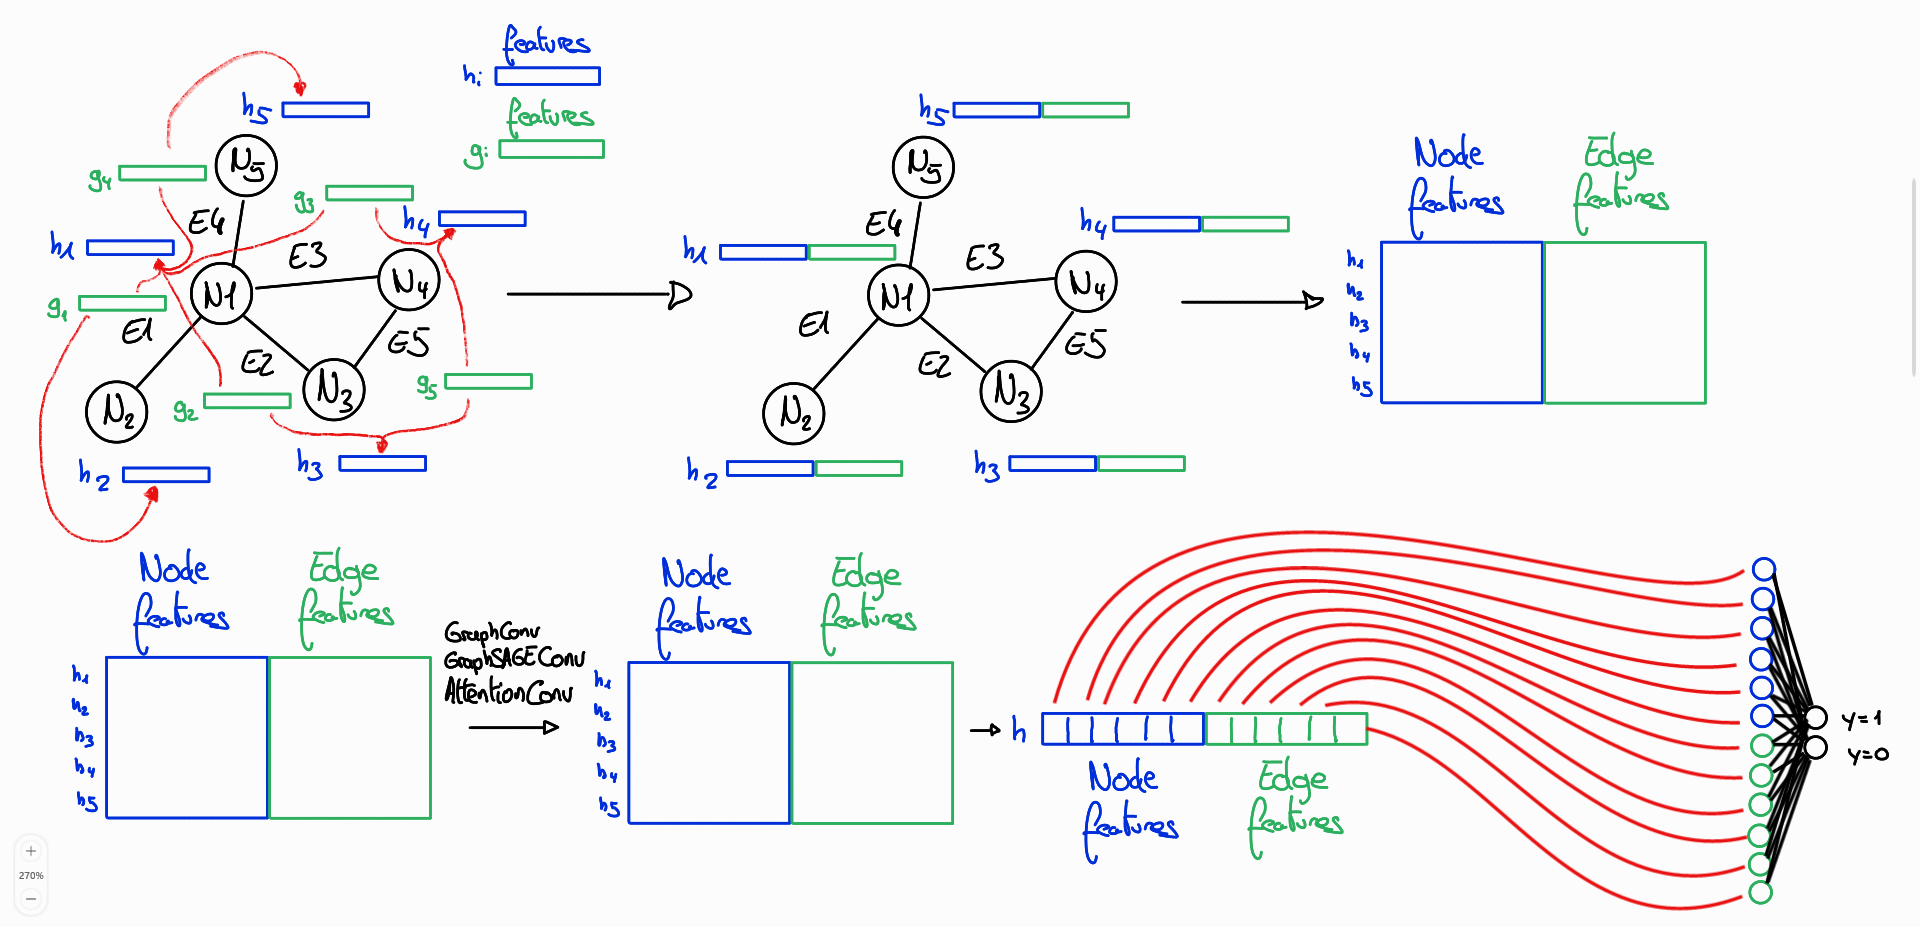

The first idea was to concatenate into the features of the nodes, a combination of the features of the edges. These features of the edges are the new features of the nodes. This offers the possibility to not change the code related to the convolution, the neural network, or the training loop.

We first define a function in panda that will allow us to add the features of the edges to the features of the nodes.

In [27]:
def concatenate_node_with_edge_features(df):
    """
    Concatenates the node features with the mean of the edge features for each node.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'node_feat', 'edge_index', 'edge_attr', etc.
        
    Returns:
        pd.DataFrame: DataFrame with updated 'node_feat'.
    """
    #iterate through each row in the DataFrame
    for index, row in df.iterrows():
        num_nodes = row['num_nodes']
        num_edge_features = len(row['edge_attr'][0])

        # Initialize lists to store the sum of edge attributes and number of edges for each node
        summed_edge_attr = [[0.0] * num_edge_features for _ in range(num_nodes)]
        edge_count = [0] * num_nodes

        # Get source and destination nodes from edge_index
        src_nodes, dst_nodes = row['edge_index']

        # Sum edge attributes for each node and count the number of edges
        for i in range(len(src_nodes)):
            # Get source and destination nodes for the current edge
            src = src_nodes[i]
            dst = dst_nodes[i]

            # Add edge attributes to the sum for the source and destination nodes
            for j in range(num_edge_features):
                summed_edge_attr[src][j] += row['edge_attr'][i][j]
                summed_edge_attr[dst][j] += row['edge_attr'][i][j]

            # Increment the edge count for the source and destination nodes
            edge_count[src] += 1
            edge_count[dst] += 1

        # Calculate the mean edge attributes for each node
        mean_edge_attr = [
            [s / max(c, 1) for s, c in zip(sum_attr, edge_count)]
            for sum_attr in summed_edge_attr
        ]

        # Concatenate node features with mean edge attributes
        new_node_feat = [feat + mean for feat, mean in zip(row['node_feat'], mean_edge_attr)]

        # Update the DataFrame
        df.at[index, 'node_feat'] = new_node_feat

    return df


We reload the data as we have previously modified a lot of things in the dataframe

In [28]:
# As we delete the edge_attr column, we need to re-load the data
df = pd.read_json('full.jsonl', lines=True)


We use the function to add the features of the edges to the features of the nodes

In [29]:
# Concatenate node features with mean edge attributes
df = concatenate_node_with_edge_features(df)

We check the number of edge features

In [30]:
print(len(df['edge_attr'][0][0]))

4


we check that the number of features in the number of features is the sum (11) of the number of features before (7) plus the number of features of the edge_attr (4).

In [31]:
# Node feature must now be 7+4 =11
print(len(df['node_feat'][0][0]))

11


As before we prefer to use an adjency matrix instead of edge_index

In [32]:
# Replace edge_index with adjacency matrices
df['edge_index'] = df.apply(lambda row: edge_index_to_adjacency_matrix(row['edge_index'], row['num_nodes']), axis=1)


#### We split the data into train, validation, test set with 70%, 15%, 15% of the data (edges 1)

In [33]:
# Define the desired percentages for training, testing, and validation
train_percent = 0.7
test_percent = 0.15
validation_percent = 0.15

# Shuffle the DataFrame randomly
df = df.sample(frac=1, random_state=42)

# Calculate the number of rows for each split
total_rows = len(df)
train_size = int(train_percent * total_rows)
test_size = int(test_percent * total_rows)

# Create training, testing, and validation sets
train_set = df.iloc[:train_size]
test_set = df.iloc[train_size:(train_size + test_size)]
validation_set = df.iloc[(train_size + test_size):]

# Print the sizes of each set
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")
print(f"Validation set size: {len(validation_set)}")


Training set size: 131
Testing set size: 28
Validation set size: 29


### Transform in pytorch and use a dataloader (edges 1)

In [34]:
# Create a custom PyTorch Dataset
train_dataset = GraphDataset(train_set)
test_dataset = GraphDataset(test_set)
validation_dataset = GraphDataset(validation_set)


In [35]:
# Create DataLoader with custom collate function
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

# Inspect the first batch, but only the shapes this time
for i, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes) in enumerate(train_dataloader):
    if i == 0:
        print("Batch:", i+1)
        print("Batch Edge Index:", batch_edge_index[0].shape)
        print("Batch Node Features:", batch_node_feat[0].shape)
        print("Batch Edge Attributes:", batch_edge_attr[0].shape)
        print("Batch Labels:", batch_y[0].shape)
        print("Batch Number of Nodes:", batch_num_nodes[0])
        
        # Stop after the first batch for demonstration
        break

Batch: 1
Batch Edge Index: torch.Size([20, 20])
Batch Node Features: torch.Size([20, 11])
Batch Edge Attributes: torch.Size([44, 4])
Batch Labels: torch.Size([1])
Batch Number of Nodes: 20


we want to determine the number of features in the graph and see if there is the same number of features in all graphs. For that we check that the min number of features is the same as the max number of features. (with edges) (edge 1)

In [36]:
# Initialize variables
max_features = 0
min_features = 10000000000

# Loop through each row in the 'node_feat' column
for row in df['node_feat']:
    # we suppose that inside the graph, all the nodes have the same number of features, we take only the number of features of the first node
    num_features = len(row[0]) if row else 0 
    # Update max and min number of features
    max_features = max(max_features, num_features)
    min_features = min(min_features, num_features)

# we set the number of features to be the max number of features
num_features_df = max_features

print("Max number of features:", max_features)
print("Min number of features:", min_features)

Max number of features: 11
Min number of features: 11


We now have a data type that can be send to pytorch and be used for training.

prepare informations for multiple training and validation
we keep the same learning rate and the same number of epochs as before

In [37]:
# We define the number of features that we want to put in the model and the number of features that is going out of the model
# We consider that they remain the same
in_features= max_features
out_features = max_features #can be different

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

Train the model with GraphConv

In [38]:
# Define the model for the convolutional layers, we can stack mutiple layers in a list
conv_layers = [GraphConv(in_features, out_features, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 70.99%
Epoch [5/20], Training Accuracy: 74.05%
Epoch [6/20], Training Accuracy: 76.34%
Epoch [7/20], Training Accuracy: 78.63%
Epoch [8/20], Training Accuracy: 81.68%
Epoch [9/20], Training Accuracy: 80.92%
Epoch [10/20], Training Accuracy: 82.44%
Epoch [11/20], Training Accuracy: 83.97%
Epoch [12/20], Training Accuracy: 86.26%
Epoch [13/20], Training Accuracy: 83.97%
Epoch [14/20], Training Accuracy: 72.52%
Epoch [15/20], Training Accuracy: 76.34%
Epoch [16/20], Training Accuracy: 76.34%
Epoch [17/20], Training Accuracy: 82.44%
Epoch [18/20], Training Accuracy: 83.21%
Epoch [19/20], Training Accuracy: 85.50%
Epoch [20/20], Training Accuracy: 81.68%
Training loss: 0.0412
Training accuracy final: 77.94%


In [39]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6228203382985346
Validation Accuracy: 79.31%


Repeat but using GraphSAGE instead of GraphConv for the convolutional layer

In [40]:
conv_layers = [GraphSAGEConv(in_features, out_features, "max", activation=nn.ReLU())]
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 68.70%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 68.70%
Epoch [8/20], Training Accuracy: 68.70%
Epoch [9/20], Training Accuracy: 73.28%
Epoch [10/20], Training Accuracy: 73.28%
Epoch [11/20], Training Accuracy: 70.23%
Epoch [12/20], Training Accuracy: 77.10%
Epoch [13/20], Training Accuracy: 77.10%
Epoch [14/20], Training Accuracy: 72.52%
Epoch [15/20], Training Accuracy: 78.63%
Epoch [16/20], Training Accuracy: 79.39%
Epoch [17/20], Training Accuracy: 76.34%
Epoch [18/20], Training Accuracy: 78.63%
Epoch [19/20], Training Accuracy: 80.92%
Epoch [20/20], Training Accuracy: 80.92%
Training loss: 0.0777
Training accuracy final: 73.02%


In [41]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6462649723579144
Validation Accuracy: 75.86%


Repeat but using Attention instead of GraphConv for the convolutional layer


In [42]:
conv_layers = [AttentionConv(in_features, out_features, "sum", activation=nn.ReLU())]
model = CustomGraphNetwork(in_features, out_features, conv_layers, "max",[])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model, training_accuracy_final, losses = train_model(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.94%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 67.18%
Epoch [10/20], Training Accuracy: 67.18%
Epoch [11/20], Training Accuracy: 67.18%
Epoch [12/20], Training Accuracy: 67.18%
Epoch [13/20], Training Accuracy: 67.18%
Epoch [14/20], Training Accuracy: 67.18%
Epoch [15/20], Training Accuracy: 67.18%
Epoch [16/20], Training Accuracy: 67.18%
Epoch [17/20], Training Accuracy: 67.18%
Epoch [18/20], Training Accuracy: 67.18%
Epoch [19/20], Training Accuracy: 67.18%
Epoch [20/20], Training Accuracy: 67.18%
Training loss: 1.4712
Training accuracy final: 67.21%


In [43]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6893690865615318
Validation Accuracy: 65.52%


__________________
# Adding edge features solution 2

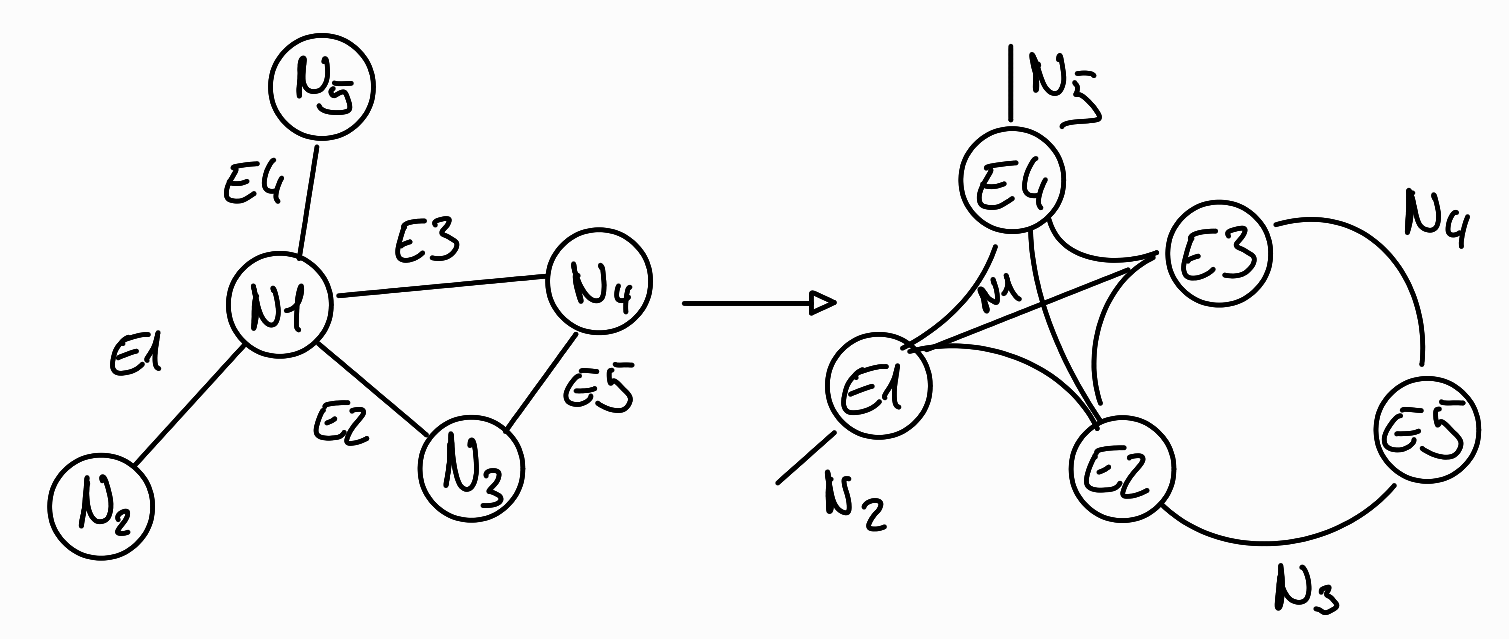

A second option was to reverse the idea of node and edges. By considering that each edge is connected to another edge by a node. By using this idea, we can convolve edge features as we did for node features

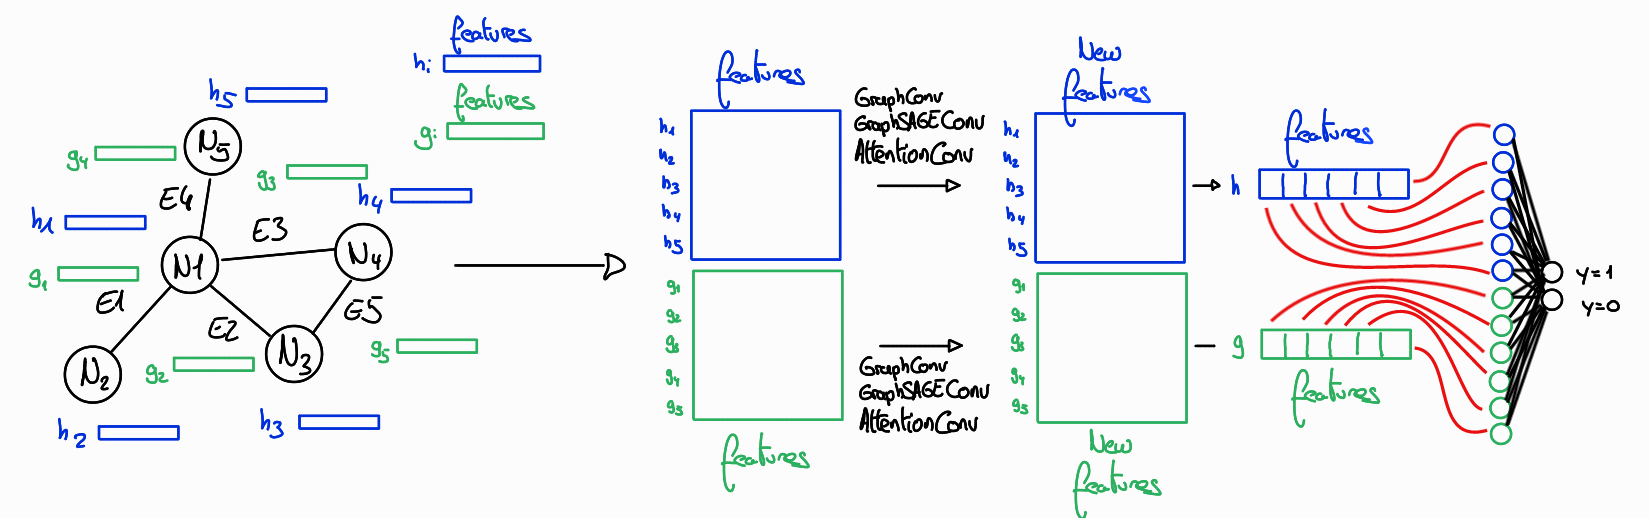

By using this idea, we can convolve edge features as we did for node features and combine the edge features pooling with the node features pooling together in the neural network. This offers the advantage that only the CustomGraphNetwork classes and the train loop need to be modified. Moreover, it gives the advantage that the edge features are not aggregated according to the nodes they belong to, but aggregates based on an adjacency matrix built for them.

We reload the data as we have previously modified a lot of things in the dataframe

In [44]:
df = pd.read_json('full.jsonl', lines=True)

We add a new column to the dataframe that contains the number of edges of each graph

In [45]:
df['num_edges'] = df['edge_attr'].apply(lambda x: len(x))

We create a function that will create an adjency matrix for the edges

In [46]:
def build_edge_adj_matrix_for_df(df):
    """
    Build edge adjacency matrices for each row in a DataFrame and add them as a new column.
    
    :param df: DataFrame containing graph info in each row.
    :return: A DataFrame with a new column "edge_adj" that contains the edge adjacency matrices.
    """
    edge_adj_matrices = []
    
    for idx, row in df.iterrows():
        edge_index = row['edge_index']
        num_edges = row['num_edges']
        
        edge_adj_matrix = np.zeros((num_edges, num_edges), dtype=int)
        
        for i in range(num_edges):
            a1, b1 = edge_index[0][i], edge_index[1][i]
            for j in range(num_edges):
                if i != j:
                    a2, b2 = edge_index[0][j], edge_index[1][j]
                    
                    if a1 == b2 or b1 == a2 or a1 == a2 or b1 == b2 :
                        edge_adj_matrix[i][j] = 1
        
        edge_adj_matrices.append(edge_adj_matrix)
        
    df['edge_adj'] = edge_adj_matrices
    return df

df = build_edge_adj_matrix_for_df(df)

Check that we incorporated the edge adjency matrix in the dataframe

In [47]:
df.head(2)

,edge_index,node_feat,edge_attr,y,num_nodes,num_edges,edge_adj
0,"[[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[1],17,38,"[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
1,"[[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[0],13,28,"[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


As before we prefer to use an node adjency matrix instead of edge_index

In [48]:
df['edge_index'] = df.apply(lambda row: edge_index_to_adjacency_matrix(row['edge_index'], row['num_nodes']), axis=1)

we pick a look at our new dataframe

In [49]:
df.head(2)

,edge_index,node_feat,edge_attr,y,num_nodes,num_edges,edge_adj
0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[1],17,38,"[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
1,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...",[0],13,28,"[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


#### We split the data into train, validation, test set with 70%, 15%, 15% of the data (edges 2)

In [50]:
# Define the desired percentages for training, testing, and validation
train_percent = 0.7
test_percent = 0.15
validation_percent = 0.15

# Shuffle the DataFrame randomly
df = df.sample(frac=1, random_state=42)

# Calculate the number of rows for each split
total_rows = len(df)
train_size = int(train_percent * total_rows)
test_size = int(test_percent * total_rows)

# Create training, testing, and validation sets
train_set = df.iloc[:train_size]
test_set = df.iloc[train_size:(train_size + test_size)]
validation_set = df.iloc[(train_size + test_size):]

# Print the sizes of each set
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")
print(f"Validation set size: {len(validation_set)}")

Training set size: 131
Testing set size: 28
Validation set size: 29


### Transform in pytorch and use a dataloader (edges 2)

from now on, we cannot use the origninal function because of these new edge features. However, we can use the same function as before but by adding the edge adjency matrix as a parameter. They are very similar to the previous function. Therefore they are written as "name_of_the_function_2"

In [51]:
class GraphDataset_2(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the GraphDataset.

        Args:
            dataframe (pandas.DataFrame): A DataFrame containing graph data, where each row
                represents a graph
        """
        self.dataframe = dataframe

    def __len__(self):
        """
        Get the number of graphs in the dataset.

        Returns:
            int: The number of graphs.
        """
        return len(self.dataframe)

    #get the value of each column
    def __getitem__(self, idx):
        """
        Get graph data at a specified index.

        Args:
            idx (int): Index of the graph in the dataset.

        Returns:
            torch.Tensor: Edge indices for the graph.
            torch.Tensor: Node features for the graph.
            torch.Tensor: Edge attributes for the graph.
            torch.Tensor: Labels for the graph.
            int: Number of nodes in the graph.
            int: Number of edges in the graph.
            torch.Tensor: Edge adjacency matrix for the edges.
        """
        
        edge_index = torch.tensor(self.dataframe.iloc[idx]['edge_index'])
        node_feat = torch.tensor(self.dataframe.iloc[idx]['node_feat'])
        edge_attr = torch.tensor(self.dataframe.iloc[idx]['edge_attr'])
        y = torch.tensor(self.dataframe.iloc[idx]['y'])
        num_nodes = self.dataframe.iloc[idx]['num_nodes']
        num_edges = self.dataframe.iloc[idx]['num_edges']
        edge_adj = torch.tensor(self.dataframe.iloc[idx]['edge_adj'])

        return edge_index, node_feat, edge_attr, y, num_nodes, num_edges, edge_adj
    
def custom_collate_2(batch):
    """
    Custom collate function for batching graph data. Given a batch of graph samples, 
    it separates and returns seven lists.

    Args:
        batch (list): A list of graph data, where each item is a tuple containing
                      (edge_index, node_feat, edge_attr, y, num_nodes, num_edges, edge_adjacency) for a graph.

    Returns:
        tuple: A tuple containing seven lists, each containing the collected data from the batch:
            - edge_index: List of adjency matrix
            - node_feat: List of node features for each graph.
            - edge_attr: List of edge attributes for each graph.
            - y: List of target labels for each graph.
            - num_nodes: List of the number of nodes for each graph.
            - num_edges: List of the number of edges for each graph.
            - edge_adjacency: List of adjency matrix for edges
    """    
    edge_index = [item[0] for item in batch]
    node_feat = [item[1] for item in batch]
    edge_attr = [item[2] for item in batch]
    y = [item[3] for item in batch]
    num_nodes = [item[4] for item in batch]
    num_edges = [item[5] for item in batch]
    egde_ajd = [item[6] for item in batch]

    
    return edge_index, node_feat, edge_attr, y, num_nodes, num_edges, egde_ajd

In [52]:
# Create a custom PyTorch Dataset
train_dataset = GraphDataset_2(train_set)
test_dataset = GraphDataset_2(test_set)
validation_dataset = GraphDataset_2(validation_set)

In [53]:
# Create DataLoader with custom collate function
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_2)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_2)

# Inspect the first batch, but only the shapes this time

for i, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes, batch_num_edges, batch_edge_adj) in enumerate(train_dataloader):
    if i == 0:
        print("Batch:", i+1)
        print("Batch Edge Index:", batch_edge_index[0].shape)
        print("Batch Node Features:", batch_node_feat[0].shape)
        print("Batch Edge Attributes:", batch_edge_attr[0].shape)
        print("Batch Labels:", batch_y[0].shape)
        print("Batch Number of Nodes:", batch_num_nodes[0])
        print("Batch Number of Edges:", batch_num_edges[0])
        print("Batch Edge Adjacency Matrix:", batch_edge_adj[0].shape)
        
        # Stop after the first batch for demonstration
        break

Batch: 1
Batch Edge Index: torch.Size([17, 17])
Batch Node Features: torch.Size([17, 7])
Batch Edge Attributes: torch.Size([38, 4])
Batch Labels: torch.Size([1])
Batch Number of Nodes: 17
Batch Number of Edges: 38
Batch Edge Adjacency Matrix: torch.Size([38, 38])


We check that the min number of features is the same as the max number of features. (with edges) (edge 2)

In [54]:
# Initialize variables
max_features_node = 0
min_features_node = 10000000000

# Loop through each row in the 'node_feat' column
for row in df['node_feat']:
    # we suppose that inside the graph, all the nodes have the same number of features, we take only the number of features of the first node
    num_features = len(row[0]) if row else 0 
    # Update max and min number of features
    max_features_node = max(max_features_node, num_features)
    min_features_node = min(min_features_node, num_features)

# we set the number of features to be the max number of features
num_features_df = max_features_node

print("Max number of features:", max_features_node)
print("Min number of features:", min_features_node)

Max number of features: 7
Min number of features: 7


In [55]:
# Initialize variables
max_features_edge = 0
min_features_edge = 10000000000

# Loop through each row in the 'node_feat' column
for row in df['edge_attr']:
    # we suppose that inside the graph, all the nodes have the same number of features, we take only the number of features of the first node
    num_features_edge = len(row[0]) if row else 0  # Check the length of the first inner list
    # Update max and min number of features
    max_features_edge = max(max_features_edge, num_features_edge)
    min_features_edge = min(min_features_edge, num_features_edge)

num_features_edge_df = max_features_edge
print("Max number of features:", max_features_edge)
print("Min number of features:", min_features_edge)

Max number of features: 4
Min number of features: 4


We now have a data type that can be send to pytorch and be used for training.

### Define graph neural network that will predict the mutagenicity

We define a GNN that will be trained which correspond to this part in the picture :

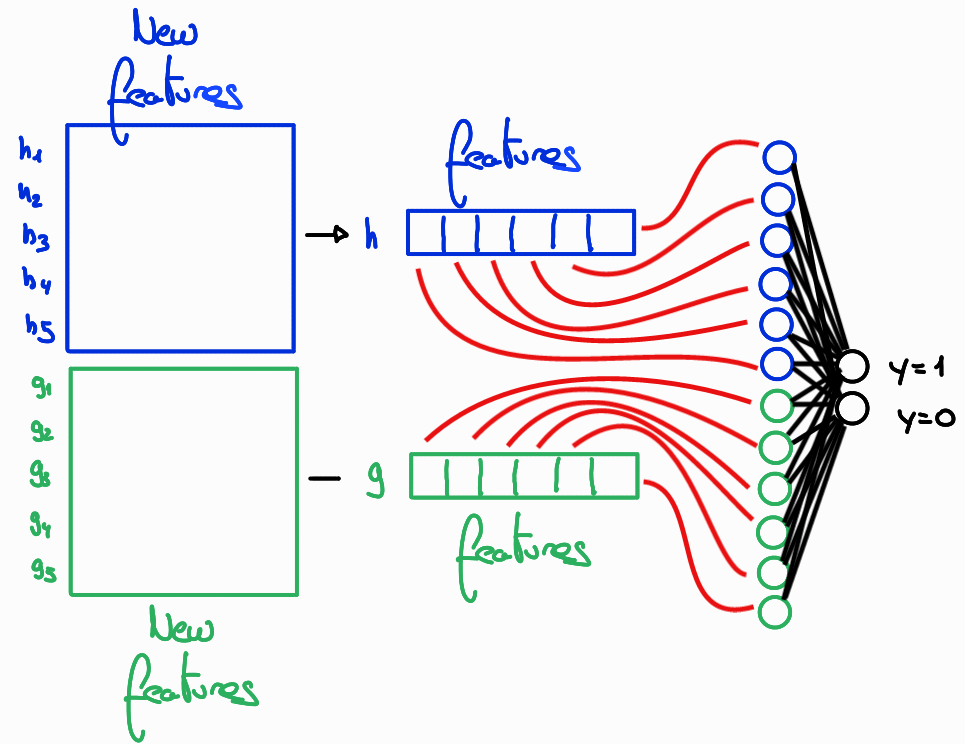

In [56]:
class CustomGraphNetwork_2(nn.Module):
    def __init__(self, num_in_features_node, num_out_features_node, num_in_features_edge, num_out_features_edge, conv_layers_node, conv_layers_edge, aggregation_node, aggregation_edge, number_of_hidden_neurons = []):
        """
        Initialize the custom graph neural network.

        Args:
            num_in_features (int): Number of input node features.
            num_out_features (int): Number of output features for each convolutional layer.
            conv_layers (nn.ModuleList): List of graph convolutional layer instances.
            aggregation (nn.Module): Instance of pooling layer.
            hidden_layer_sizes (list): List of hidden layer sizes for fully connected layers.
        """       
        super(CustomGraphNetwork_2, self).__init__()
        # Infeatures: number of input features per node
        self.num_in_features_node = num_in_features_node
        # Outfeatures: number of output features per node
        self.num_out_features_node = num_out_features_node
        # Infeatures: number of input features per edge
        self.num_in_features_edge = num_in_features_edge
        # Outfeatures: number of output features per edge
        self.num_out_features_edge = num_out_features_edge
        
        # Convolutional layers
        self.conv_layers_node = nn.ModuleList(conv_layers_node)
        self.conv_layers_edge = nn.ModuleList(conv_layers_edge)
        
        # Aggregation function: which is applied to aggregate into a shape 1, out_features        
        self.aggregation_node = aggregation_node
        self.aggregation_edge = aggregation_edge
        
        # list of hidden layer sizes for fully connected layers
        self.number_of_hidden_neurons = number_of_hidden_neurons
        self.fully_connected = nn.ModuleList()
        in_features_of_fully_connected = self.num_out_features_node + self.num_out_features_edge
        # build of the fully connected layers
        for i in number_of_hidden_neurons:
            self.fully_connected.append(nn.Linear(in_features_of_fully_connected, i))
            in_features_of_fully_connected = i
        # add the last fully connected layer
        self.fully_connected.append(nn.Linear(in_features_of_fully_connected, 2))    
        
    def forward(self, x,adj, edge_x, edge_adj):
        """
        Forward pass through the custom graph neural network.

        Args:
            x (Tensor): Input node features, shape (num_nodes, num_in_features).
            adj (Tensor): Adjacency matrix, shape (num_nodes, num_nodes).

        Returns:
            Tensor: with the probality of each graph to be in the class 0 or 1
        """
        # Pass input through each graph convolutional layer for the nodes   
        for conv_layer_node in self.conv_layers_node:
            x = conv_layer_node(x, adj)  # Pass adjacency matrix to the convolutional layer
        node_graph_output = x
        
        
        # Pass input through each graph convolutional layer for the edges   
        for conv_layer_edge in self.conv_layers_edge:
            edge_x = conv_layer_edge(edge_x, edge_adj)  # Pass adjacency matrix to the convolutional layer
        edge_graph_output = edge_x

        
        # Apply global pooling along the node dimension (dimension 1)
        if self.aggregation_node == "mean" :
            node_graph_output = torch.mean(node_graph_output, dim=0, keepdim=False)
        elif self.aggregation_node == "max" :
            node_graph_output, _ = torch.max(node_graph_output, dim=0, keepdim=False)
        else :
            raise ValueError("Aggregation_node type not supported.")
        
        # Apply global pooling along the edge dimension (dimension 1)
        if self.aggregation_edge == "mean" :
            edge_graph_output = torch.mean(edge_graph_output, dim=0, keepdim=False)
        elif self.aggregation_edge == "max" :
            edge_graph_output, _ = torch.max(edge_graph_output, dim=0, keepdim=False)
            
        else :
            raise ValueError ("Aggregation_edge type not supported.")
        
        # Concatenate the node and edge graph outputs
        graph_output = torch.cat((node_graph_output, edge_graph_output), dim=0)
              

        # Apply the fully connected layers    
        for fc_layer in self.fully_connected:
            graph_output = fc_layer(graph_output)
            
            
        # Apply softmax activation
        softmax_output = torch.softmax(graph_output, dim=0)

        return softmax_output

### Train with edge features solution 2, , create a function that will train the model and return the loss and accuracy

redefine the training function for egde consideration

In [57]:
def train_model_2(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate):
    """
    Train a GNN using a training loop.

    Parameters:
    - model: The machine learning model to be trained.
    - optimizer: The optimizer for updating model parameters.
    - criterion: The loss function used for optimization.
    - train_dataloader: DataLoader providing training data.
    - num_epochs: The number of training epochs.
    - learning_rate: The learning rate for gradient descent.

    Returns:
    - trained_model: The trained machine learning model.
    - training_accuracy: The overall training accuracy across all epochs.
    - losses: A list of losses during training.
    """
    # Initialize variables for training accuracy and losses    
    correct_train_predictions = 0
    total_train_samples = 0
    losses = []
    
    # Clear gradients
    optimizer.zero_grad()
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        # Initialize variables for training accuracy and losses for each epoch
        sub_accuracy_list = []
        correct_train_predictions_epoch = 0
        total_train_samples_epoch = 0

        # Loop through each batch in the training dataloader
        for idx, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes, batch_num_edges, batch_edge_adj) in enumerate(train_dataloader):
           
            # loop through each graph in the batch
            for i in range(len(batch_edge_index)):
                
                # Extract features, adjency matrix and labels for the current graph
                node_features = batch_node_feat[i].float()
                edge_features = batch_edge_attr[i].float()
                adj_matrix = batch_edge_index[i].float()
                adj_matrix_edge = batch_edge_adj[i].float()
                ground_truth_labels = batch_y[i].clone()
                
                # Convert to one-hot labels
                one_hot_labels = torch.zeros((ground_truth_labels.size(0), 2))
                one_hot_labels.scatter_(1, ground_truth_labels.view(-1, 1), 1).squeeze_()
               
                # Forward pass
                output = model(node_features, adj_matrix, edge_features, adj_matrix_edge)   
                
                # Calculate the predicted class based on probability threshold (e.g., 0.5)
                predicted_class = (output > 0.5).long()
                condition = (predicted_class == one_hot_labels).all().item()
                # condition : if the prediction == ground truth -> add 1 to the correct_train_predictions
                if condition:
                    correct_train_predictions += 1
                    correct_train_predictions_epoch = correct_train_predictions_epoch + 1
                #Calculate the total number of samples
                total_train_samples += 1
                total_train_samples_epoch = total_train_samples_epoch + 1  
                


                
                # transform the output to probabilities for loss calculation
                output_probabilities = output[1]  # Select the second element (probability for class 1)
                ground_truth_labels =  ground_truth_labels.squeeze()
                output_logits = torch.log(output_probabilities / (1 - output_probabilities))
                # Calculate the loss
                loss = criterion(output_logits, ground_truth_labels.float())
                losses.append(loss.cpu().detach().numpy())



                # Backpropagation
                #optimizer.zero_grad()
                loss.backward()
                # optimizer.step()
                # Optimizer step does not work, Update weights using gradient descent we do this manually because I do not understand why optimizer.step() does not work :@              
                with torch.no_grad(): 
                    for name, param in model.named_parameters():
                        param -= learning_rate * param.grad
                            

        # Calculate training accuracy
        training_accuracy = (correct_train_predictions_epoch / total_train_samples_epoch) * 100
        sub_accuracy_list.append(training_accuracy)
        
        # Print training accuracy for each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {training_accuracy:.2f}%")

        #Calculate the mean of the accuracy for all the epochs
        training_accuracy_final = (correct_train_predictions / total_train_samples) * 100

    return model, training_accuracy_final, losses


### Validate with edges features 2, create a function that will validate the model and return the loss and accuracy

In [58]:
def validate_model_2(model, validation_dataloader, criterion):
    """
    Validate a GNN using a validation loop.

    Parameters:
    - model: The machine learning model to be trained.
    - validation_dataloader: DataLoader providing training data.
    - criterion: The loss function used for optimization.

    Returns:
    - average_validation_loss: the average validation loss
    - validation_accuracy: The overall validation accuracy across all epochs.
    """
    # Set the model to evaluation mode (no gradient updates)
    model.eval()
    
    # Initialize variables for validation accuracy and loss
    # We have for each two numbers so we can calculate the mean of the accuracy and loss
    total_validation_loss = 0.0
    validation_batches = 0

    correct_train_predictions = 0
    total_train_samples = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for idx, (batch_edge_index, batch_node_feat, batch_edge_attr, batch_y, batch_num_nodes, batch_num_edges, batch_edge_adj) in enumerate(validation_dataloader):
            for i in range(len(batch_edge_index)):
                
                # Extract features, adjency matrix and labels for the current graph
                node_features = batch_node_feat[i].float()
                edge_features = batch_edge_attr[i].float()
                adj_matrix = batch_edge_index[i].float()
                adj_matrix_edge = batch_edge_adj[i].float()
                ground_truth_labels = batch_y[i].clone().detach()

                # Convert labels to one-hot labels
                one_hot_labels = torch.zeros((ground_truth_labels.size(0), 2))
                one_hot_labels.scatter_(1, ground_truth_labels.view(-1, 1), 1).squeeze_()

                # Forward pass
                output = model(node_features, adj_matrix, edge_features, adj_matrix_edge)

                # Calculate the predicted class based on probability of the output
                predicted_class = (output > 0.5).long()  # Assuming class 1 corresponds to index 1
                condition = (predicted_class == one_hot_labels).all().item()
                # condition : if the prediction == ground truth -> add 1 to the correct_train_predictions
                if condition:
                    correct_train_predictions += 1
                total_train_samples += 1

                # Compute the validation loss (no backpropagation)
                validation_loss = criterion(output, one_hot_labels)

                # add the validation loss to the total validation loss
                total_validation_loss += validation_loss.item()
                validation_batches += 1

    # Calculate the average validation loss
    average_validation_loss = total_validation_loss / validation_batches
    # Calculate validation accuracy
    validation_accuracy = (correct_train_predictions / total_train_samples) * 100

    return average_validation_loss, validation_accuracy


prepare informations for multiple training and validation

In [59]:
# We define the number of features that we want to put in the model and the number of features that is going out of the model
# We consider that they remain the same

in_features_node= max_features_node
out_features_node = max_features_node #can be different
in_features_edge= max_features_edge
out_features_edge = max_features_edge #can be different

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()


In [60]:
# Define the model for the convolutional layers for nodes, we can stack mutiple layers in a list
conv_layers_node = [GraphConv(in_features_node, out_features_node, "max", activation=nn.ReLU())]
# Define the model for the convolutional layers for edges, we can stack mutiple layers in a list
conv_layers_edge = [GraphConv(in_features_edge, out_features_edge, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork_2(in_features_node, out_features_node, in_features_edge, out_features_edge, conv_layers_node, conv_layers_edge, "max", "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model_2(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 70.23%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 69.47%
Epoch [6/20], Training Accuracy: 80.92%
Epoch [7/20], Training Accuracy: 80.15%
Epoch [8/20], Training Accuracy: 81.68%
Epoch [9/20], Training Accuracy: 81.68%
Epoch [10/20], Training Accuracy: 80.92%
Epoch [11/20], Training Accuracy: 81.68%
Epoch [12/20], Training Accuracy: 82.44%
Epoch [13/20], Training Accuracy: 79.39%
Epoch [14/20], Training Accuracy: 77.10%
Epoch [15/20], Training Accuracy: 81.68%
Epoch [16/20], Training Accuracy: 80.15%
Epoch [17/20], Training Accuracy: 74.05%
Epoch [18/20], Training Accuracy: 74.05%
Epoch [19/20], Training Accuracy: 81.68%
Epoch [20/20], Training Accuracy: 81.68%
Training loss: 0.2303
Training accuracy final: 77.02%


In [61]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model_2(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6450578488152603
Validation Accuracy: 79.31%


In [62]:
# Define the model for the convolutional layers for nodes, we can stack mutiple layers in a list
conv_layers_node = [GraphSAGEConv(in_features_node, out_features_node, "max", activation=nn.ReLU())]
# Define the model for the convolutional layers for edges, we can stack mutiple layers in a list
conv_layers_edge = [GraphSAGEConv(in_features_edge, out_features_edge, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork_2(in_features_node, out_features_node, in_features_edge, out_features_edge, conv_layers_node, conv_layers_edge, "max", "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model_2(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 67.18%
Epoch [10/20], Training Accuracy: 69.47%
Epoch [11/20], Training Accuracy: 68.70%
Epoch [12/20], Training Accuracy: 67.18%
Epoch [13/20], Training Accuracy: 70.99%
Epoch [14/20], Training Accuracy: 70.99%
Epoch [15/20], Training Accuracy: 72.52%
Epoch [16/20], Training Accuracy: 74.05%
Epoch [17/20], Training Accuracy: 74.05%
Epoch [18/20], Training Accuracy: 74.05%
Epoch [19/20], Training Accuracy: 72.52%
Epoch [20/20], Training Accuracy: 71.76%
Training loss: 0.6529
Training accuracy final: 69.54%


In [63]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model_2(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.672813238768742
Validation Accuracy: 68.97%


In [64]:
# Define the model for the convolutional layers for nodes, we can stack mutiple layers in a list
conv_layers_node = [AttentionConv(in_features_node, out_features_node, "sum", activation=nn.ReLU())]
# Define the model for the convolutional layers for edges, we can stack mutiple layers in a list
conv_layers_edge = [AttentionConv(in_features_edge, out_features_edge, "sum", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork_2(in_features_node, out_features_node, in_features_edge, out_features_edge, conv_layers_node, conv_layers_edge, "max", "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model_2(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 67.18%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 67.18%
Epoch [10/20], Training Accuracy: 67.18%
Epoch [11/20], Training Accuracy: 67.18%
Epoch [12/20], Training Accuracy: 67.18%
Epoch [13/20], Training Accuracy: 67.18%
Epoch [14/20], Training Accuracy: 67.18%
Epoch [15/20], Training Accuracy: 67.18%
Epoch [16/20], Training Accuracy: 67.18%
Epoch [17/20], Training Accuracy: 67.18%
Epoch [18/20], Training Accuracy: 67.18%
Epoch [19/20], Training Accuracy: 67.18%
Epoch [20/20], Training Accuracy: 67.18%
Training loss: 0.4851
Training accuracy final: 67.18%


In [65]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model_2(model, validation_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.706594300681147
Validation Accuracy: 65.52%


We test finaly the best model on the test set, the best results are obtained with the GraphConv model, with a learning rate of 1E-4, using the second method for the edge intergration

In [66]:
learning_rate = 1e-4

# Define the model for the convolutional layers for nodes, we can stack mutiple layers in a list
conv_layers_node = [GraphConv(in_features_node, out_features_node, "max", activation=nn.ReLU())]
# Define the model for the convolutional layers for edges, we can stack mutiple layers in a list
conv_layers_edge = [GraphConv(in_features_edge, out_features_edge, "max", activation=nn.ReLU())]
# Define the model of the GNN
model = CustomGraphNetwork_2(in_features_node, out_features_node, in_features_edge, out_features_edge, conv_layers_node, conv_layers_edge, "max", "max",[])
# Define the optimizer, which is used to update the weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model using the training loop
model, training_accuracy_final, losses = train_model_2(model, optimizer, criterion, train_dataloader, num_epochs, learning_rate)

#print the loss and accuracy during the training process
print(f"Training loss: {losses[-1]:.4f}")
print(f"Training accuracy final: {training_accuracy_final:.2f}%")

Epoch [1/20], Training Accuracy: 64.89%
Epoch [2/20], Training Accuracy: 67.18%
Epoch [3/20], Training Accuracy: 67.18%
Epoch [4/20], Training Accuracy: 67.18%
Epoch [5/20], Training Accuracy: 67.18%
Epoch [6/20], Training Accuracy: 67.18%
Epoch [7/20], Training Accuracy: 67.18%
Epoch [8/20], Training Accuracy: 67.18%
Epoch [9/20], Training Accuracy: 67.94%
Epoch [10/20], Training Accuracy: 73.28%
Epoch [11/20], Training Accuracy: 73.28%
Epoch [12/20], Training Accuracy: 74.81%
Epoch [13/20], Training Accuracy: 70.23%
Epoch [14/20], Training Accuracy: 74.81%
Epoch [15/20], Training Accuracy: 73.28%
Epoch [16/20], Training Accuracy: 70.99%
Epoch [17/20], Training Accuracy: 75.57%
Epoch [18/20], Training Accuracy: 69.47%
Epoch [19/20], Training Accuracy: 69.47%
Epoch [20/20], Training Accuracy: 74.05%
Training loss: 0.2237
Training accuracy final: 70.11%


The final test with the best model

In [67]:
# Print the final loss and the final accuracy
average_loss, accuracy = validate_model_2(model, test_dataloader, criterion)
print(f"Validation Loss: {average_loss}")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss: 0.6438114430223193
Validation Accuracy: 82.14%


We only obtained an accuracy of 82.1 % which is good but not great.